NOTE: Upload mp4 to project file and change name in code to analyze that image.

# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# import dependencies
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from IPython.display import display, Javascript, Image

from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io
import html
import time

!wget --no-check-certificate \
    https://user-images.githubusercontent.com/110051214/198838460-de8d962a-8603-4807-9ac0-90d294297a40.jpeg \
    -O black_lexus_1.jpg

!wget --no-check-certificate \
    https://user-images.githubusercontent.com/51682972/198846038-06e29367-6d78-4ecf-80b2-128c7437b720.jpeg \
    -O white_lexus_1.jpg

!wget --no-check-certificate \
     https://user-images.githubusercontent.com/51682972/198846041-8cf9a4f8-6ab7-4220-9de1-3bf01be50392.jpeg \
     -O blue_lexus_1.jpg

!wget --no-check-certificate \
     https://user-images.githubusercontent.com/51682972/198846034-b8a696e2-d36c-4292-a4c7-1189f3971f8b.jpeg \
     -O blue_lexus_2.jpg

--2022-11-01 01:49:07--  https://user-images.githubusercontent.com/110051214/198838460-de8d962a-8603-4807-9ac0-90d294297a40.jpeg
Resolving user-images.githubusercontent.com (user-images.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to user-images.githubusercontent.com (user-images.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87519 (85K) [image/jpeg]
Saving to: ‘black_lexus_1.jpg’

black_lexus_1.jpg   100%[===================>]  85.47K  --.-KB/s    in 0.002s  

2022-11-01 01:49:07 (52.7 MB/s) - ‘black_lexus_1.jpg’ saved [87519/87519]

--2022-11-01 01:49:07--  https://user-images.githubusercontent.com/51682972/198846038-06e29367-6d78-4ecf-80b2-128c7437b720.jpeg
Resolving user-images.githubusercontent.com (user-images.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to user-images.githubusercontent.com (user-images.githubusercontent.c

# Main

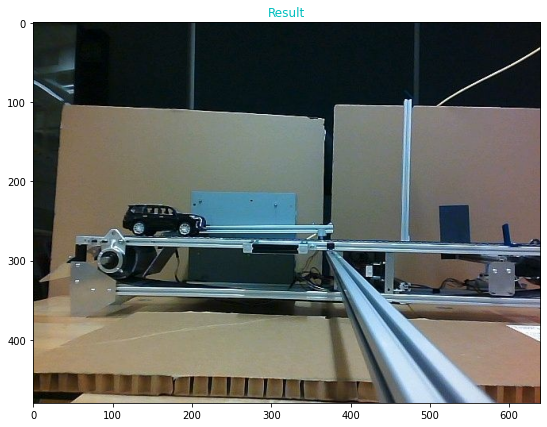

In [ ]:
#Constants
debugOutput = False

#Crop
# I accidentally mixed up x and y

X1 = 75 
X2 = 150
Y1 = 30
Y2 = 500

'''
X1 = 245
X2 = 280
Y1 = 100
Y2 = 600
'''

SIZESCALE = 3
WIDTH = (X2-X1) * SIZESCALE
HEIGHT = (Y2-Y1) * SIZESCALE

def houghCircleDetector(imgOriginal):
    img = imgOriginal.copy()

    #crop
    img = img[X1:X2,Y1:Y2].copy()
    #resize
    img = cv2.resize(img,(HEIGHT,WIDTH),interpolation=cv2.INTER_LANCZOS4)

    #process to make shapes distinct
    #convert to binary
    img_gry = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #ret,img_Otsubin = cv2.threshold(img_gry,127,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img = cv2.adaptiveThreshold(img_gry,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,15,15)
    #blur
    #img = cv2.GaussianBlur(img,(19,19),cv2.BORDER_DEFAULT)

    #find circles
    frontWheel = [0,0,0]
    try:
        circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,minDist=20,param1=1,param2=30, minRadius=10, maxRadius=50)
        circles = np.uint16(np.around(circles))
        #draw them and find which is front wheel
        for val in circles[0,:]:
            #undo crop and resize
            val[2] = val[2]/SIZESCALE
            val[0] = val[0]/SIZESCALE+Y1
            val[1] = val[1]/SIZESCALE+X1
            #draw
            cv2.circle(imgOriginal,(val[0],val[1]),val[2],(0,255,0),2)
            #check if front wheel
            if frontWheel[2] == 0:
                frontWheel = val
            elif val[0] > frontWheel[0]:
                frontWheel = val
    except:
        {}#print("No Circles")

    #draw square around front wheel
    if frontWheel[2] != 0:
        cv2.rectangle(imgOriginal, (frontWheel[0]-frontWheel[2], frontWheel[1]-frontWheel[2]),
            (frontWheel[0]+frontWheel[2], frontWheel[1]+frontWheel[2]), (0,0,255), 2)
        cv2.line(imgOriginal, (400, 100), (400, 300), (0,0,255), 2)
    
    #draw debug
    if debugOutput:
        plt.subplot(122),plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)),plt.title('Debug',color='c')
        plt.show()
    return imgOriginal, frontWheel

#run for testing
path_to_img = 'black_lexus_1.jpg'
img = cv2.imread(path_to_img)

plt.figure(figsize=(20,10))
newImg, wheel = houghCircleDetector(img)
plt.subplot(121),plt.imshow(cv2.cvtColor(newImg,cv2.COLOR_BGR2RGB)),plt.title('Result',color='c')
plt.show()

# Photo

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  #print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  #faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  #for (x,y,w,h) in faces:
  #    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

<IPython.core.display.Javascript object>

Saved to photo.jpg


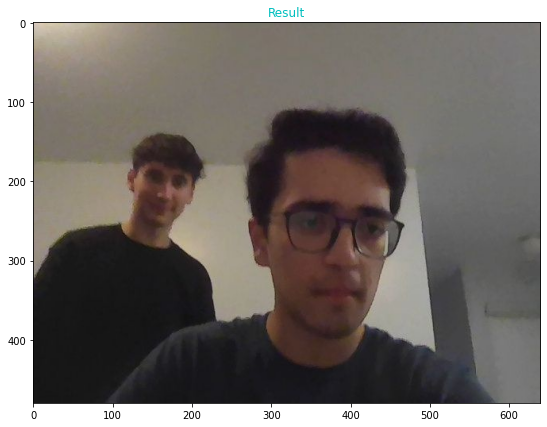

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  img, wheel = houghCircleDetector(cv2.imread('photo.jpg'))

  plt.figure(figsize=(20,10))
  plt.subplot(121),plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)),plt.title('Result',color='c')
  plt.show()

except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

#Video

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from IPython.display import HTML

def re_encode_video(video_path):
    print(f"Re-encoding video, this might take some time, please be patient.")
    #added -r 30, otherwise, for some reason it records 1000FPS as metadata for the Astra
    os.system(f"ffmpeg -y -i {video_path} -vcodec libx264 -r 30 temp.mp4")
    os.system(f"rm {video_path}")
    os.system(f"mv temp.mp4 {video_path}")
    print(f"Done encoding!")
    
def show_video(video_path, video_width = 640, reencode = False):
   
  video_file = open(video_path, "r+b").read()

  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")
 
video_path = "black_lexus_1.mp4"

In [ ]:
from google.colab.patches import cv2_imshow
from IPython.display import clear_output

# Initiate video capture for video file. video.mp4 should be in your working directory
cap = cv2.VideoCapture(video_path)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

res=(int(width), int(height))

fourcc = cv2.VideoWriter_fourcc(*'MP4V') #codec: this format should play in Chrome/Colab
out_filename = "output.mp4"
out = cv2.VideoWriter(out_filename, fourcc, 30.0, res)

print(f"Processing video.")

frame = None
while cap.isOpened():

    is_success, frame = cap.read()

    if not is_success:
        break

    #Do some image processing here. As an example, do point detection
    processed_frame, wheel = houghCircleDetector(frame)

    out.write(processed_frame) #write the processed images to an mp4 file

out.release() 

print(f"Done! Saved in working directory with name {out_filename}")

cap.release()

re_encode_video("output.mp4") #for some reason the codecs from OpenCV fourcc don't play nicely with Colab, so re-encode
show_video("output.mp4", video_width= 640) 

Processing video.
Done! Saved in working directory with name output.mp4
Re-encoding video, this might take some time, please be patient.
Done encoding!




# Streaming

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Looking for wheel...'
# initialze bounding box to empty
bbox = ''
count = 0 


while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # get front wheel
    processedImage, frontWheel = houghCircleDetector(img)

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    bbox_array = cv2.rectangle(bbox_array,(frontWheel[0]-frontWheel[2], frontWheel[1]-frontWheel[2]),
            (frontWheel[0]+frontWheel[2], frontWheel[1]+frontWheel[2]),(0,0,255),2)
    #overlay crop
    bbox_array = cv2.rectangle(bbox_array,(Y1,X1),(Y2,X2),(0,0,255),2)

    #find and print distance from reference point to front wheel, update every frame
    if frontWheel[0] - Y1 > 0:
      label_html = "Distance from beginning of the conveyor belt: ", (frontWheel[0] - Y1)

    x_of_bar = 400
    #cv2.line(processedImage, (x_of_bar, 150), (x_of_bar, 75), (0,255,0), 2)
    bbox_array = cv2.line(bbox_array, (x_of_bar, 150), (x_of_bar, 75), (255,0,0), 2)

    if (frontWheel[0] > x_of_bar):
      final_ss = processedImage
      ss_filename = 'ss.jpg'
      ss = cv2.imwrite(ss_filename, final_ss)
      label_html = 'Finished'
      break

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>